# Modeling spike data with `multidms.jaxmodels`

In [602]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [603]:
replicate = "lib_1"
# func_score_type = "loose_bottle"
func_score_type = "observed_phenotype"
do_truncate_nonsense = True
output_dir = 'simulations_output'

reference = 'h1'
l2reg = 1e-4
fusionreg = 2.0
block_iters = 50
block_tol = 1e-4

ge_tol = 1e-5
ge_maxiter = 1000
ge_maxls = 30

cal_tol = 1e-4
cal_maxiter = 1000
cal_maxls = 30

loss_fn = "functional_score_loss"
beta_naught_init = {
    "h1": 5.0,
    "h2": 3.41
}
alpha_init = {
    "h1": 6.0,
    "h2": 6.0
}
warmstart = False
beta_clip = (-10, 10)
# loss_fn = "count_loss"

loss_kwargs = {"δ": 1.0}
# loss_kwargs = {}

# global_epistasis = "Identity"
global_epistasis = "Sigmoid"

functional_score_min = -6
functional_score_max = 2
# pseudocount = 0.
min_pre_count = 200
min_post_count = 1

In [604]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [605]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [606]:
df = (
    pd.read_csv(
        "../scaled_down_parameter_output/simulated_functional_scores.csv", 
        keep_default_na=True
    )
    .infer_objects()
    .assign(
        aa_substitutions = lambda x: x['aa_substitutions'].fillna('')
    )
    .assign(
        n_subs = lambda x: x['aa_substitutions'].str.split().str.len()
    )
    .rename(
        columns={
            "library": "replicate",
            "homolog": "condition",
        }
    )
)
df


/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_85155/1258441135.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,S5D A9S Q20V W40V P43R,observed_phenotype,-5.691377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-3.061013,5
2,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
3,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
4,lib_1,h1,R14H L33M F45R V47P,observed_phenotype,-5.936064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-5.526753,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682813,lib_2,h2,L2I C31P F34K E50S,tight_bottle,-4.536798,pre-selection,1.531123,14.0,1.0,2636910.0,6331855.0,0.5,4.0,>1 nonsynonymous,-3.105203,4
682814,lib_2,h2,L23G E50S,tight_bottle,-5.907636,pre-selection,4.329249,12.0,0.0,2636910.0,6331855.0,0.5,2.0,>1 nonsynonymous,-0.468845,2
682815,lib_2,h2,R13L V39L,tight_bottle,-0.126276,pre-selection,0.242197,12.0,27.0,2636910.0,6331855.0,0.5,2.0,>1 nonsynonymous,0.648985,2
682816,lib_2,h2,V6F G7L F34V Y47E,tight_bottle,-5.351243,pre-selection,4.407606,8.0,0.0,2636910.0,6331855.0,0.5,4.0,>1 nonsynonymous,-15.626246,4


In [607]:
# # df = pd.read_csv("simulated_bottleneck_cbf.csv", keep_default_na=False)
# df = pd.read_csv("../scaled_down_parameter_output/simulated_bottleneck_cbf.csv", keep_default_na=False)
# # df = pd.read_csv("../scaled_down_parameter_output/simulated_functional_scores.csv", keep_default_na=False)
# df.rename(
#     columns={
#         "library": "replicate",
#         "homolog": "condition",
#         "n_aa_substitutions": "n_subs",
#     },
#     inplace=True,
# )
# df

<Axes: >

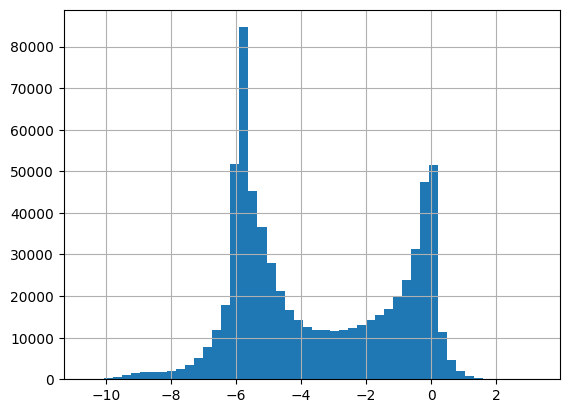

In [608]:
df.func_score.hist(bins=50)

In [609]:
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,S5D A9S Q20V W40V P43R,observed_phenotype,-5.691377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-3.061013,5
2,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
3,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
4,lib_1,h1,R14H L33M F45R V47P,observed_phenotype,-5.936064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-5.526753,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682813,lib_2,h2,L2I C31P F34K E50S,tight_bottle,-4.536798,pre-selection,1.531123,14.0,1.0,2636910.0,6331855.0,0.5,4.0,>1 nonsynonymous,-3.105203,4
682814,lib_2,h2,L23G E50S,tight_bottle,-5.907636,pre-selection,4.329249,12.0,0.0,2636910.0,6331855.0,0.5,2.0,>1 nonsynonymous,-0.468845,2
682815,lib_2,h2,R13L V39L,tight_bottle,-0.126276,pre-selection,0.242197,12.0,27.0,2636910.0,6331855.0,0.5,2.0,>1 nonsynonymous,0.648985,2
682816,lib_2,h2,V6F G7L F34V Y47E,tight_bottle,-5.351243,pre-selection,4.407606,8.0,0.0,2636910.0,6331855.0,0.5,4.0,>1 nonsynonymous,-15.626246,4


In [610]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,S5D A9S Q20V W40V P43R,observed_phenotype,-5.691377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-3.061013,5
2,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
3,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
4,lib_1,h1,R14H L33M F45R V47P,observed_phenotype,-5.936064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-5.526753,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170491,lib_1,h2,E27T F34N,observed_phenotype,-1.404150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,1.015163,2
170492,lib_1,h2,N3R H24S V26G,observed_phenotype,-4.223353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.024447,3
170493,lib_1,h2,N22Y V39S,observed_phenotype,-5.150655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-2.094713,2
170494,lib_1,h2,W8Y P43V,observed_phenotype,-5.754703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-4.708559,2


In [611]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.000000
1,h1,lib_1,A10*,1,0.0,0.0,-5.919686
2,h1,lib_1,A10* C26K E27I M29R S46I,5,0.0,0.0,-5.959841
3,h1,lib_1,A10* C26K F34G G35M W40E E50N,6,0.0,0.0,-5.959811
4,h1,lib_1,A10* C26L,2,0.0,0.0,-5.932902
...,...,...,...,...,...,...,...
113539,h2,lib_1,Y47V E50G,2,0.0,0.0,-2.782865
113540,h2,lib_1,Y47V E50R,2,0.0,0.0,-0.128890
113541,h2,lib_1,Y47V L49T,2,0.0,0.0,-0.895004
113542,h2,lib_1,Y47W,1,0.0,0.0,0.023954


In [612]:
df.query("aa_substitutions == ''")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.0
56714,h2,lib_1,,0,0.0,0.0,0.0


In [613]:
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score


Ah, G50W doesn't hit the threshold.

### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

In [614]:
if func_score_type != "observed_phenotype":
    g = sns.relplot(
        x=df.pre_count[df.aa_substitutions != ""],
        y=df.post_count[df.aa_substitutions != ""],
        col=df.condition[df.aa_substitutions != ""],
        s=10, alpha=0.1,
        height=3, aspect=1,
        clip_on=False,
        )
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xscale("symlog", linthresh=1, linscale=0.5)
    plt.yscale("symlog", linthresh=1, linscale=0.5)

    for ax in g.axes.flat:
        condition = ax.get_title().split(" = ")[1]
        df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
        df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
        ax.axvline(min_pre_count, color="red", linestyle="--")
        ax.axhline(min_post_count, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

In [615]:
df.shape

(113544, 7)

### Mutation number filtering

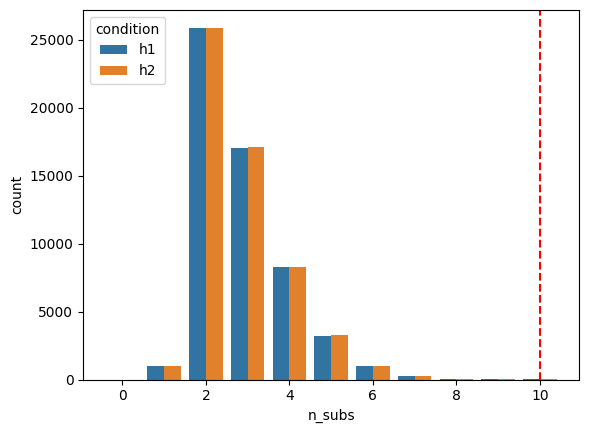

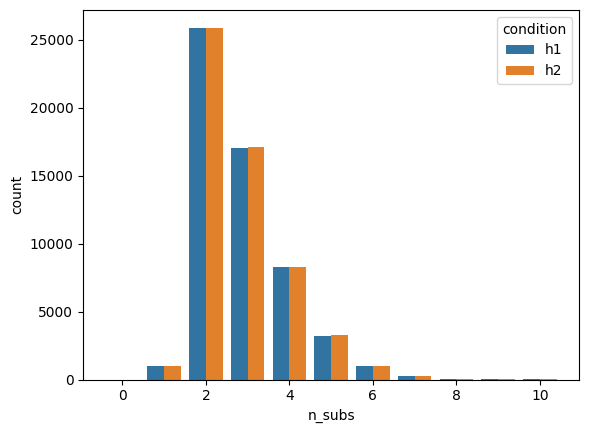

In [616]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [617]:
df.shape

(113544, 7)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [618]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [619]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

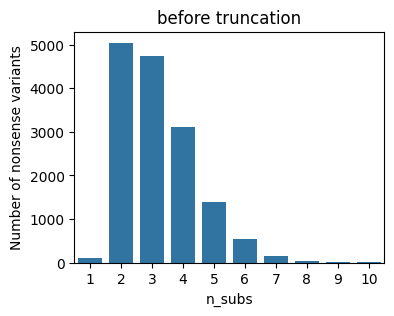

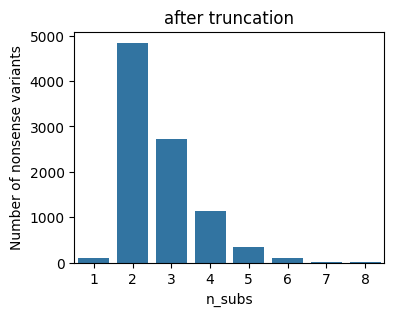

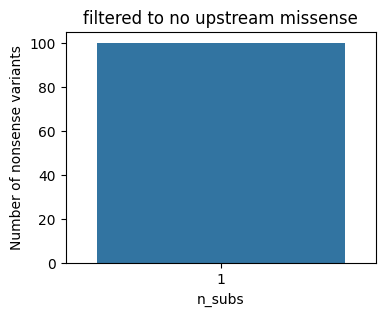

In [620]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_85155/702988830.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


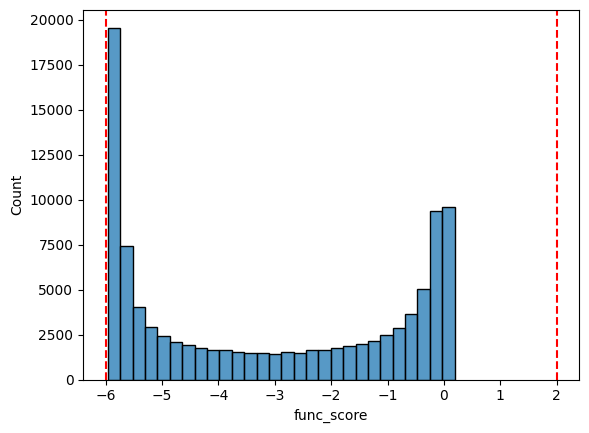

In [621]:
# df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

# def group_wt_ref(df_group):
#     wts = df_group.query("aa_substitutions == ''")
#     assert wts.shape[0] == 1, wts
#     df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
#     return df_group

# df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

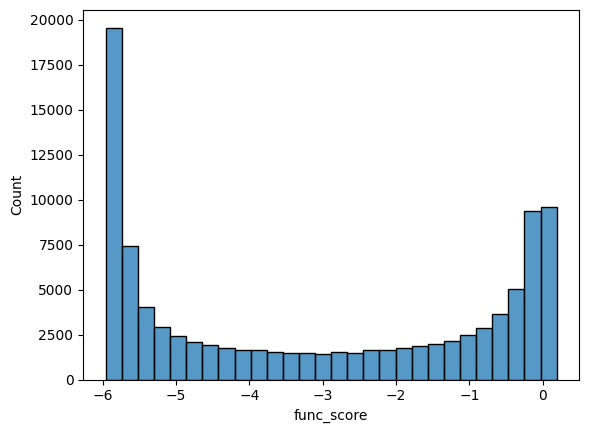

In [622]:
sns.histplot(df.func_score)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [623]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Create a `jaxmodels.Data` object, containing the array data

In [624]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[1000],
  X=BCOO(int8[49212, 1000], nse=137215),
  functional_scores=f64[49212],
  pre_count_wt=f64[],
  post_count_wt=f64[],
  pre_counts=f64[49212],
  post_counts=f64[49212]
)

In [625]:
data_sets

{'h1': Data(
   x_wt=i8[1000],
   X=BCOO(int8[49212, 1000], nse=137215),
   functional_scores=f64[49212],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[49212],
   post_counts=f64[49212]
 ),
 'h2': Data(
   x_wt=i8[1000],
   X=BCOO(int8[49291, 1000], nse=600993),
   functional_scores=f64[49291],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[49291],
   post_counts=f64[49291]
 )}

In [626]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.0
53786,h2,lib_1,,0,0.0,0.0,0.0


In [627]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


0.0
0.0
0.0
0.0


In [628]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

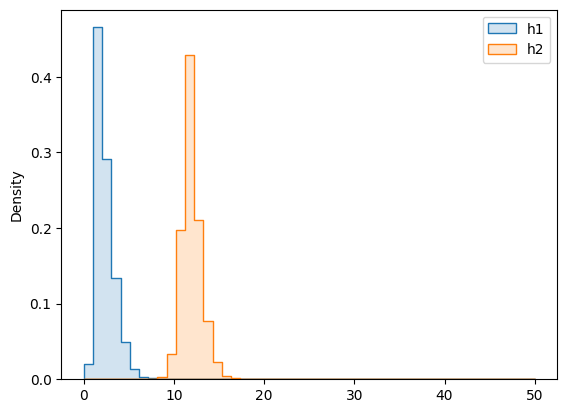

In [629]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

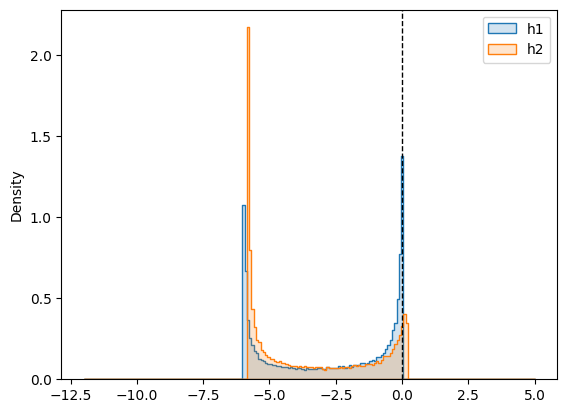

In [630]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [631]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    warmstart=warmstart,
    beta_naught_init=beta_naught_init,
    beta_clip_range=beta_clip,
    alpha_init=alpha_init
    )

iter 1:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=1.97e-06, stepsize=8.2e+03, iter=323
  β_bundle: error=1.12e-04, stepsize=2.0e+00, iter=1000
  h2 sparsity=67.5%
  obj=2.15e-03
  objective_error=9.98e-01
iter 2:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=9.78e-06, stepsize=2.0e+03, iter=24
  β_bundle: error=9.72e-06, stepsize=8.0e+00, iter=308
  h2 sparsity=71.1%
  obj=1.99e-03
  objective_error=1.62e-04
iter 3:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=8.57e-06, stepsize=2.0e+03, iter=22
  β_bundle: error=7.79e-06, stepsize=8.0e+00, iter=179
  h2 sparsity=72.1%
  obj=1.85e-03
  objective_error=1.37e-04
iter 4:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=8.80e-06, stepsize=2.0e+03, iter=20
  β_bundle: error=6.72e-06, stepsize=8.0e+00, iter=183
  h2 sparsity=72.2%


## Loss trajectory

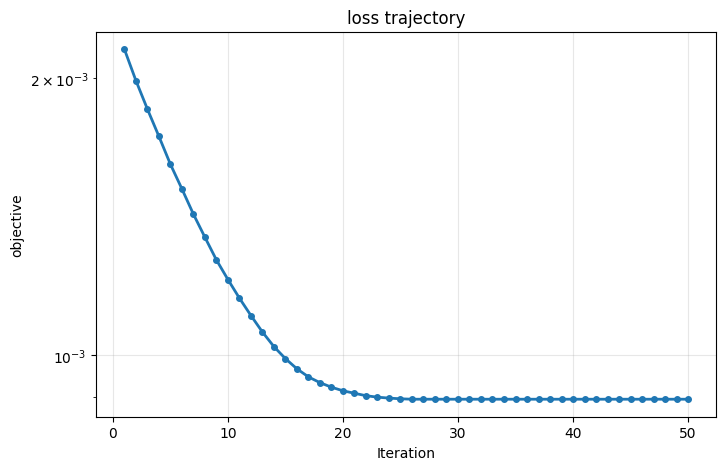

Final loss: 0.000896
Total iterations: 50


In [632]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

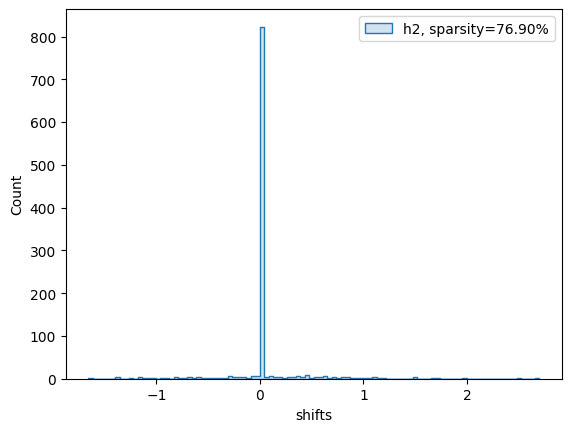

In [633]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [634]:
simu_mut_effects = pd.read_csv("../scaled_down_parameter_output/simulated_muteffects.csv", keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


Find ground truth sparsity

In [635]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


(810, 1000, 0.81)

Functional score correlations

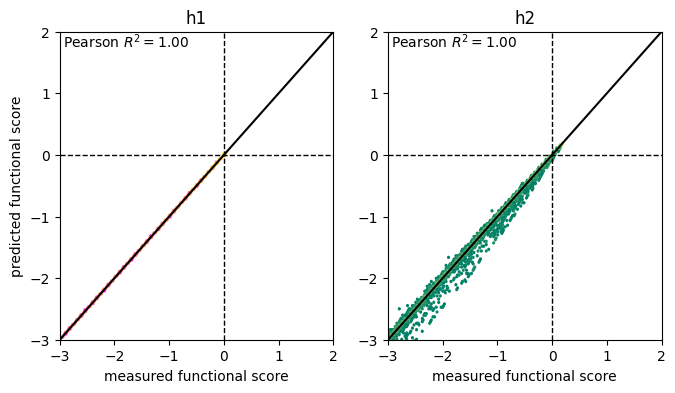

In [636]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

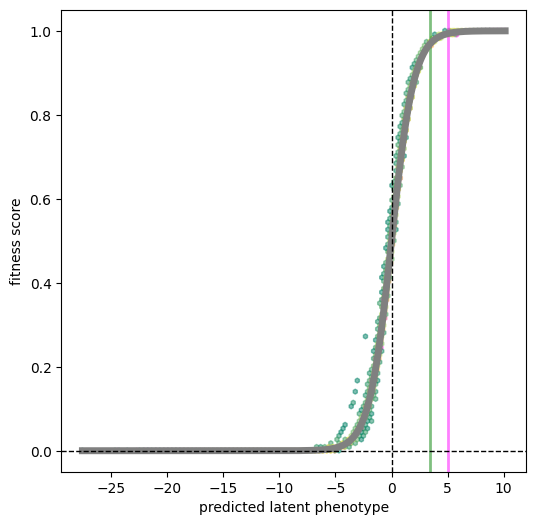

In [637]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
# plot the global epistasis function

for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=100, alpha=0.5)

φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
# plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

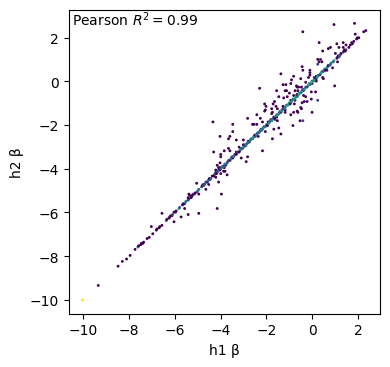

In [638]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [639]:
model.α

{'h1': Array(6., dtype=float64, weak_type=True),
 'h2': Array(6., dtype=float64, weak_type=True)}

Distribution of $\beta$

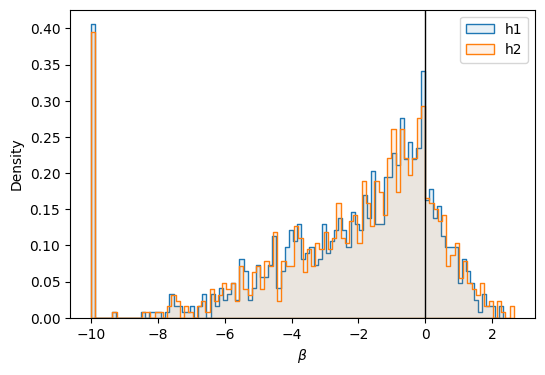

In [640]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [641]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2
0,F1A,F,1,A,178,179
1,F1C,F,1,C,94,96
2,F1D,F,1,D,102,101
3,F1E,F,1,E,91,90
4,F1G,F,1,G,209,208
...,...,...,...,...,...,...
995,E50T,E,50,T,178,176
996,E50V,E,50,V,218,210
997,E50W,E,50,W,51,50
998,E50Y,E,50,Y,89,87


In [642]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(1000, (49212, 1000))

In [643]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,
F1A,178,179,-2.019904,-2.019904,0.0
F1C,94,96,-0.417896,-0.417896,0.0
F1D,102,101,-2.928083,-2.928083,0.0
F1E,91,90,-1.516189,-1.516189,0.0
F1G,209,208,-4.732551,-4.732551,0.0
...,...,...,...,...,...
E50T,178,176,-0.942469,-0.942469,0.0
E50V,218,210,-0.989254,-0.989254,0.0
E50W,51,50,-1.192451,-1.192451,0.0


In [644]:
mutations_df.beta_h1.isna().sum()

np.int64(0)

In [645]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False
F1C,-0.417888,False,0.0,-0.417888,F,F,False
F1D,-2.928096,False,0.0,-2.928096,F,F,False
F1E,-1.516192,False,0.0,-1.516192,F,F,False
F1G,-4.732575,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False
E50V,-0.989250,False,0.0,-0.989250,E,E,False
E50W,-1.192453,False,0.0,-1.192453,E,E,False


In [646]:
simu_mut_effects.shape

(1000, 7)

In [647]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

set()

In [648]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False,178,179,-2.019904,-2.019904,0.0
F1C,-0.417888,False,0.0,-0.417888,F,F,False,94,96,-0.417896,-0.417896,0.0
F1D,-2.928096,False,0.0,-2.928096,F,F,False,102,101,-2.928083,-2.928083,0.0
F1E,-1.516192,False,0.0,-1.516192,F,F,False,91,90,-1.516189,-1.516189,0.0
F1G,-4.732575,False,0.0,-4.732575,F,F,False,209,208,-4.732551,-4.732551,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False,178,176,-0.942469,-0.942469,0.0
E50V,-0.989250,False,0.0,-0.989250,E,E,False,218,210,-0.989254,-0.989254,0.0
E50W,-1.192453,False,0.0,-1.192453,E,E,False,51,50,-1.192451,-1.192451,0.0


In [649]:
merged_df.shape

(1000, 12)

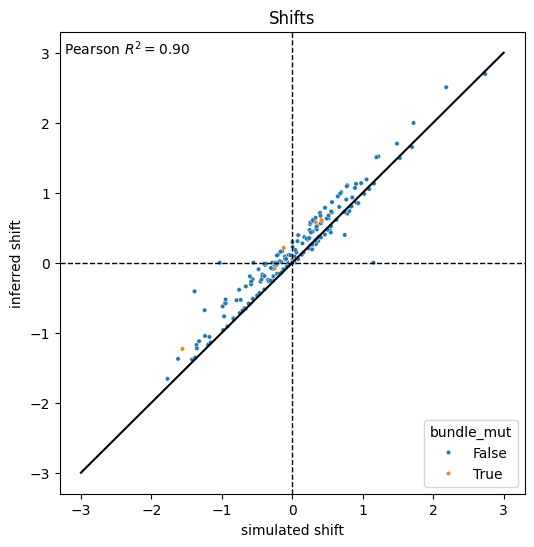

In [650]:
# plot inferred shifts vs simulated shifts for h2

plt.figure(figsize=(6, 6))
x = merged_df['simulated_shift']#.query("mutation.str.contains('19')")["simulated_shift"]
y = merged_df['shift_h2']#.query("mutation.str.contains('19')")["shift_h2"]
# plt.scatter(x, y, alpha=1, s=10)
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
sns.scatterplot(
    merged_df,#.query("mutation.str.contains('19')"), 
    x="simulated_shift", 
    y="shift_h2", 
    alpha=1, 
    s=10,
    hue="bundle_mut"
    )
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

In [651]:
merged_df = merged_df.assign(abs_shift_error_h2 = (merged_df["simulated_shift"] - merged_df["shift_h2"]).abs())
merged_df.sort_values("abs_shift_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,abs_shift_error_h2
mutation,,,,,,,,,,,,,
A9H,-7.435186,True,1.152969,-6.282217,A,D,False,95,94,-7.434817,-7.434817,0.000000,1.152969
H31M,-6.170295,True,-1.030085,-7.200381,H,C,False,51,54,-6.170277,-6.170277,0.000000,1.030085
H31N,-5.999990,True,-1.387046,-7.387037,H,C,False,84,84,-5.999920,-6.408516,-0.408596,0.978450
A9G,-5.407310,True,-1.244148,-6.651458,A,D,False,190,192,-5.407288,-6.085664,-0.678376,0.565773
A9N,-6.073048,True,-0.552204,-6.625252,A,D,False,87,85,-6.072982,-6.072982,0.000000,0.552204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
K21*,-10.000000,False,0.000000,-10.000000,K,K,False,1,1,-9.997528,-9.997528,0.000000,0.000000
N22A,0.063646,False,0.000000,0.063646,N,N,False,176,178,0.063629,0.063629,0.000000,0.000000
N22C,-4.835256,False,0.000000,-4.835256,N,N,False,101,101,-4.835219,-4.835219,0.000000,0.000000


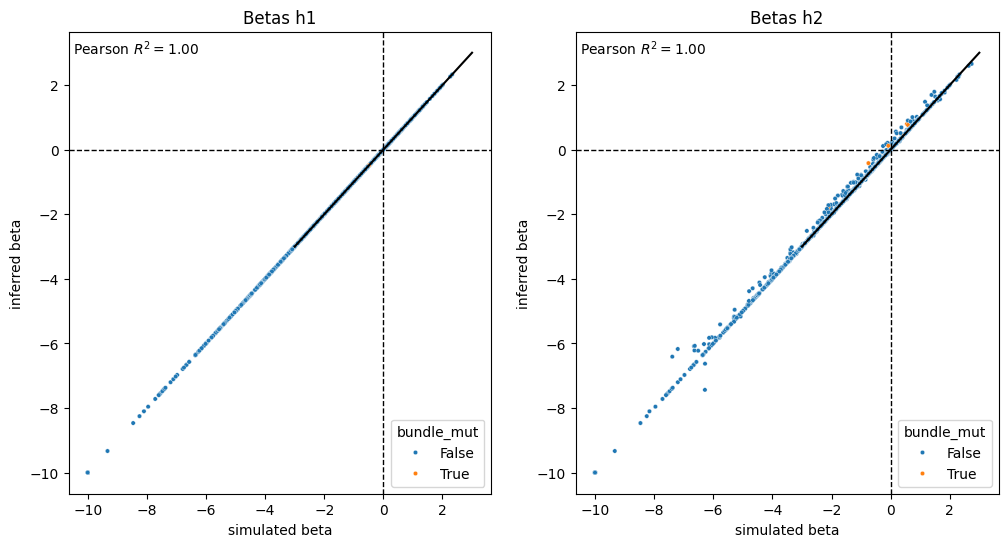

In [652]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    # plt.scatter(x, y, alpha=1, s=10)
    sns.scatterplot(merged_df, x=f"simulated_beta_{d}", y=f"beta_{d}", alpha=1, s=10, hue="bundle_mut")
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")

In [653]:
merged_df = merged_df.assign(abs_beta_error_h2 = (merged_df["simulated_beta_h2"] - merged_df["beta_h2"]).abs())
merged_df.sort_values("abs_beta_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,abs_shift_error_h2,abs_beta_error_h2
mutation,,,,,,,,,,,,,,
A9H,-7.435186,True,1.152969,-6.282217,A,D,False,95,94,-7.434817,-7.434817,0.000000,1.152969,1.152600e+00
H31M,-6.170295,True,-1.030085,-7.200381,H,C,False,51,54,-6.170277,-6.170277,0.000000,1.030085,1.030103e+00
H31N,-5.999990,True,-1.387046,-7.387037,H,C,False,84,84,-5.999920,-6.408516,-0.408596,0.978450,9.785208e-01
A9G,-5.407310,True,-1.244148,-6.651458,A,D,False,190,192,-5.407288,-6.085664,-0.678376,0.565773,5.657946e-01
A9N,-6.073048,True,-0.552204,-6.625252,A,D,False,87,85,-6.072982,-6.072982,0.000000,0.552204,5.522697e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E50M,-1.038305,False,0.000000,-1.038305,E,E,False,48,48,-1.038305,-1.038305,0.000000,0.000000,4.446645e-08
C37V,-1.511645,False,0.000000,-1.511645,C,C,False,182,182,-1.511645,-1.511645,0.000000,0.000000,2.558950e-08
V41Q,-0.245064,False,0.000000,-0.245064,V,V,False,83,80,-0.245064,-0.245064,0.000000,0.000000,1.014181e-08
